In [1]:
# Train cifar10 through tensorflow dataset

In [2]:
import sys
import time
import argparse

import tenncor as tc

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

W0320 12:15:00.422724 4653231552 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
nbatch = 4
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0001
show_every_n = 5
nepochs = 10

ds = tfds.load('cifar10',
    split=tfds.Split.TRAIN,
    batch_size=nbatch,
    shuffle_files=True)
cifar = tfds.as_numpy(ds)

W0320 12:15:01.100796 4653231552 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_datasets/core/dataset_builder.py:494: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


In [4]:
sess = tc.Session()

raw_inshape = [dim.value for dim in ds.output_shapes['image']]
raw_inshape[0] = nbatch
train_outshape = [nbatch, 10]
print(raw_inshape)

train_input = tc.EVariable(raw_inshape, label="trainin")
train_output = tc.EVariable(train_outshape, label="trainout")

[4, 32, 32, 3]


In [5]:
# batch, height, width, in
# construct CNN
model = tc.layer.link([ # minimum input shape of [1, 32, 32, 3]
    tc.layer.conv([5, 5], 3, 16,
        weight_init=tc.norm_xavier_init(0.5),
        zero_padding=[2, 2]), # outputs [nbatch, 32, 32, 16]
    tc.layer.bind(tc.relu),
    tc.layer.bind(lambda x: tc.nn.max_pool2d(x, [1, 2]),
        inshape=tc.Shape([1, 32, 32, 16])), # outputs [nbatch, 16, 16, 16]
    tc.layer.conv([5, 5], 16, 20,
        weight_init=tc.norm_xavier_init(0.3),
        zero_padding=[2, 2]), # outputs [nbatch, 16, 16, 20]
    tc.layer.bind(tc.relu),
    tc.layer.bind(lambda x: tc.nn.max_pool2d(x, [1, 2]),
        inshape=tc.Shape([1, 16, 16, 20])), # outputs [nbatch, 8, 8, 20]
    tc.layer.conv([5, 5], 20, 20,
        weight_init=tc.norm_xavier_init(0.1),
        zero_padding=[2, 2]), # outputs [nbatch, 8, 8, 20]
    tc.layer.bind(tc.relu),
    tc.layer.bind(lambda x: tc.nn.max_pool2d(x, [1, 2]),
        inshape=tc.Shape([1, 8, 8, 20])), # outputs [nbatch, 4, 4, 20]

    tc.layer.dense([4, 4, 20], [10], # weight has shape [10, 4, 4, 20]
        weight_init=tc.norm_xavier_init(0.5),
        bias_init=tc.zero_init(),
        dims=[[0, 1], [1, 2], [2, 3]]), # outputs [nbatch, 10]
    tc.layer.bind(lambda x: tc.softmax(x, 1, 1))
], train_input)

In [6]:
def cross_entropy_loss(Label, Pred):
    return -tc.reduce_sum(Label * tc.log(Pred))

In [7]:
normalized = train_input / 255. - 0.5
train_err = tc.sgd_train(model, normalized, model,
    lambda assocs: tc.approx.adagrad(assocs, 0.01), err_func=cross_entropy_loss)
sess.track([train_err])
tc.optimize(sess, "cfg/optimizations.json")

In [8]:
terr = []
try:
    for i, data in enumerate(cifar):
        labels = np.zeros((nbatch, 10))
        for j, label in enumerate(data['label']):
            labels[j][label] = 1
        print('expected label:\n{}'.format(labels))
        train_input.assign(data['image'].astype(np.float))
        train_output.assign(labels.astype(np.float))
        for j in range(nepochs):
            sess.update_target([train_err])
            trained_err = train_err.get()
            print('done epoch {}'.format(j))
            if j % show_every_n == show_every_n - 1:
                err = np.average(trained_err)
                print(('training {}th image, epoch {}\n'+
                    'training error:\n{}\n'+
                    'average training error:\n{}')
                    .format(i, j + 1, trained_err, err))
                terr.append(err)
except KeyboardInterrupt:
    print("Interrupted")

expected label:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
done epoch 0
done epoch 1
done epoch 2
done epoch 3
done epoch 4
training 0th image, epoch 5
training error:
0.6083331108093262
average training error:
0.6083331108093262
done epoch 5
done epoch 6
done epoch 7
done epoch 8
done epoch 9
training 0th image, epoch 10
training error:
0.27398979663848877
average training error:
0.27398979663848877
expected label:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
done epoch 0
done epoch 1
done epoch 2
done epoch 3
done epoch 4
training 1th image, epoch 5
training error:
0.17716822028160095
average training error:
0.17716822028160095
done epoch 5
done epoch 6
done epoch 7
done epoch 8
done epoch 9
training 1th image, epoch 10
training error:
0.053541604429483414
average training error:
0.053541604429483414
expected

done epoch 3
done epoch 4
training 16th image, epoch 5
training error:
3.6359491787152365e-05
average training error:
3.6359491787152365e-05
done epoch 5
done epoch 6
done epoch 7
done epoch 8
done epoch 9
training 16th image, epoch 10
training error:
3.624027522164397e-05
average training error:
3.624027522164397e-05
expected label:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Interrupted


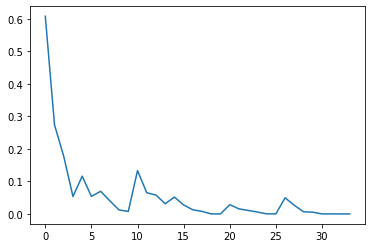

In [9]:
plt.plot(list(range(len(terr))), terr)